## Data set Car Evaluation
que foi retirado do [repositório](https://archive.ics.uci.edu/ml/datasets/car+evaluation) da UCI
Esse DataSet possui 6 atributos categoricos para classificação de carros : Preço de
compra, preço de manutenção, número de portas, número de pessoas, tamanho da
mala e segurança. Todos os atributos têm valores discretos.
Existem 4 classificações para os carros: Não aceitável, aceitável, bom e
muito bom.
No arquivo de DataSet existem 1728 instâncias e esse grupo de instâncias
cobre todo o espaço de possibilidades de combinações de atributos. Um detalhe é que o número de carros classificados como não aceitável é bem maior que os outros.

unacc 1210 (70.023 %) acc 384 (22.222 %) good 69 ( 3.993 %) v-good 65 ( 3.762 %)

## Atributos
CAR car acceptability  ( classes )
* PRICE overall price 
1. buying buying price (buying)
2. maint price of the maintenance (maint)
* TECH technical characteristics 
    * COMFORT comfort
        3. doors number of doors (doors)
        4. persons capacity in terms of persons to carry (persons)
        5. lug_boot the size of luggage boot (lug_boot)
7. safety estimated safety of the car (safety)

### Escolha dos atributos para o treinamento
Utilizando o [Weka](https://www.cs.waikato.ac.nz/ml/weka/) para calcular o ganho de informação por atributo (geralmente usado em árvores de decisão), ou seja, o quão homogeas os grupos de amostras ficam após passerem pelo atributo. Vimos que o número de portas tinha um valor baixo de informação, no entanto, ao retirarmos ele os resultados foram piores. Acreditamos que isso se deve ao fato de já termos poucos em nosso dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import time
import seaborn as sns

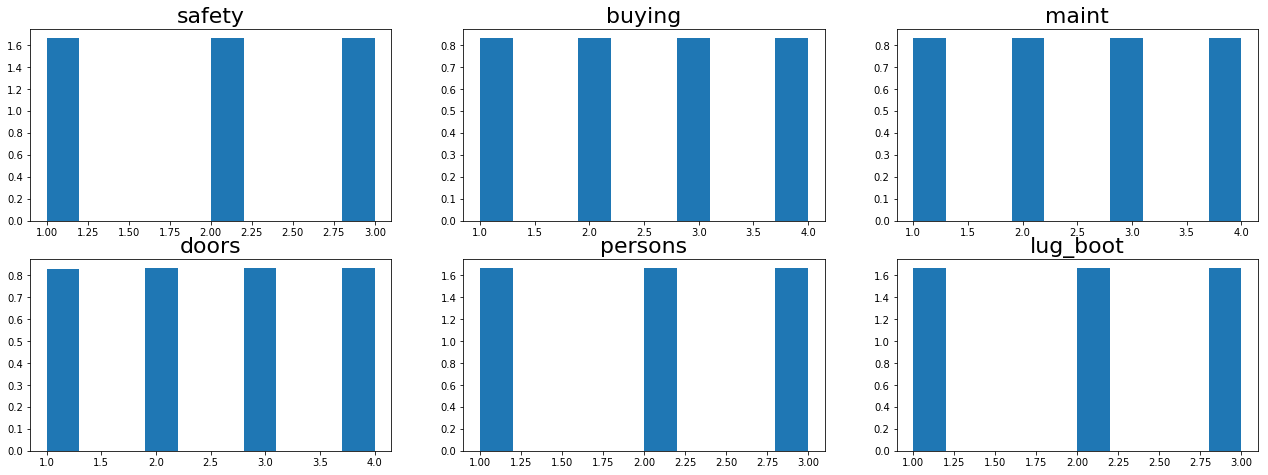

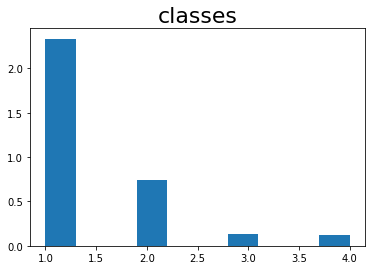

In [2]:
# classificação dos carros

UNACC = 3  # não aceitável
ACC = 1    # aceitável
GOOD = 2   # bom
VG = 4     # Muito bom

seed = 7#12  # para manter todos os resultados reproduziveis
np.random.seed(seed)

# load dataset
dataframe = pd.read_csv(r"https://raw.githubusercontent.com/Pedro-Magalhaes/Teste/master/t1_2/car_evaluation.csv")

# Assign names to Columns
dataframe.columns = ['buying','maint','doors','persons','lug_boot','safety','classes']

# Encode Data, transformando o valor dos atributos de strings para numeros
dataframe.buying.replace(('vhigh','high','med','low'),(1,2,3,4), inplace=True)
dataframe.maint.replace(('vhigh','high','med','low'),(1,2,3,4), inplace=True)
dataframe.doors.replace(('2','3','4','5more'),(1,2,3,4), inplace=True)
dataframe.persons.replace(('2','4','more'),(1,2,3), inplace=True)
dataframe.lug_boot.replace(('small','med','big'),(1,2,3), inplace=True)
dataframe.safety.replace(('low','med','high'),(1,2,3), inplace=True)
dataframe.classes.replace(('unacc','acc','good','vgood'),(1,2,3,4), inplace=True)

dataset = dataframe.values

# x -> atributos do problema são 5, de 0 até 5
X = dataset[:,0:6]
# Y -> classificação de cada caso, coluna 6 do dataframe
Y = np.asarray(dataset[:,6], dtype="S6")
# Usando a função do sklearn para separar os casos de treino e de teste
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2)

outcome_labels = {0: 'unacc', 1:'acc', 2:'good', 3:'vgood'}

def showDataHist(dataFrame):
    plt.figure(figsize=(22,12))
    plt.subplot(3,3,1)    
    plt.hist(dataframe.safety, density=1)
    plt.title('safety',fontdict={'fontsize':22})
    plt.subplot(3,3,2)
    plt.hist(dataframe.buying, density=1)
    plt.title('buying',fontdict={'fontsize':22})
    plt.subplot(3,3,3)
    plt.hist(dataframe.maint, density=1)
    plt.title('maint',fontdict={'fontsize':22})
    plt.subplot(3,3,4)
    plt.hist(dataframe.doors, density=1)
    plt.title('doors',fontdict={'fontsize':22})
    plt.subplot(3,3,5)
    plt.hist(dataframe.persons, density=1)
    plt.title('persons',fontdict={'fontsize':22})
    plt.subplot(3,3,6)
    plt.hist(dataframe.lug_boot, density=1)
    plt.title('lug_boot',fontdict={'fontsize':22})
    plt.show()
    plt.hist(dataframe.classes, density=1)
    plt.title('classes',fontdict={'fontsize':22})
    plt.show()
   
    # Criando o Histograma com a distribuição das classes
    
    # Histograma de cada atributo do problema
    #plt.hist(dataframe.buying)

    plt.show()
showDataHist(dataframe)


### Apesar da ocorrência de classes estar desproporcional, os atributos estão bem distribuídos.

# Algoritmo SVM
### Com esse algoritmo obtivemos nossos melhores resultados, fizemos um ajuste manual dos parametros tentando chegar em uma boa acurácia
## Parametros:
### Kernel 
* Kernel é o tipo de formulação matematica do svm
* Utilizamos o kernel "rbf" (Radial Basis Function)
    * Formulação: exp( -gamma * (|| x - x' ||)^2 )
* O gamma varia afeta o raio de influência de cada instância de treino, com valores menores aumentamos a influência e com maiores diminuimos.
* o C varia a margem de aceitação das instancias de treino, um C maior torna o algoritmo mais custoso com uma precisão maior, ja um C mais baixo torna a margem maior tornando o algoritmo menos custoso em troca de precisão

#### [saiba mais](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py)


In [3]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def printResults(errosSum,accuracy):
    # imprimindo o numero de elementos classificados errados
    print('Misclassified samples using SVM are: {}'.format(errosSum))
    # imprimindo a acuracia
    print('Classification Accuracy of SVM is {} '.format(accuracy))


# Fazendo a standartização dos dados ler o site a seguir para explicação:
# Obtivemos resultados melhores ulizando esse passo
#  https://towardsdatascience.com/effect-of-feature-standardization-on-linear-support-vector-machines-13213765b812
def standartizeTrainData(X_Train,X_Test):   
    sc = StandardScaler()
    sc.fit(X_Train)
    X_train_std=sc.transform(X_Train)
    X_test_std=sc.transform(X_Test)
    return X_test_std, X_train_std

def standartize(data):
    sc = StandardScaler()
    sc.fit(data)
    data_std=sc.transform(data)        
    return data_std

def trainSVM(X_Train,X_Test,Y_Train,Y_Test, kernel , C, gamma ):
    start = time.time()
    X_test_std,X_train_std = standartizeTrainData(X_Train,X_Test)
    svc = svm.SVC(kernel=kernel, C=C ,gamma=gamma)
    svc.fit(X_train_std,Y_Train)
    print('tempo de treino: {}s'.format(time.time()-start))
    start = time.time()
    s_pred=svc.predict(X_test_std)
    print('tempo de classificação dos casos de teste: {}s'.format(time.time()-start))
    accuracy = accuracy_score(Y_Test,s_pred)
    errosSum = (Y_Test!=s_pred).sum()
    return svc, s_pred, accuracy, errosSum




C:\Users\pfsma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\pfsma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\pfsma\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


tempo de treino: 0.0470423698425293s
tempo de classificação dos casos de teste: 0.0040035247802734375s
Misclassified samples using SVM are: 1
Classification Accuracy of SVM is 0.9971098265895953 


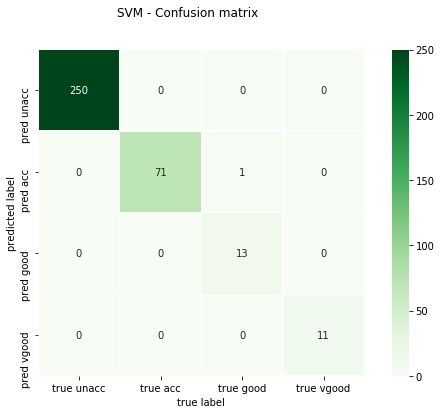

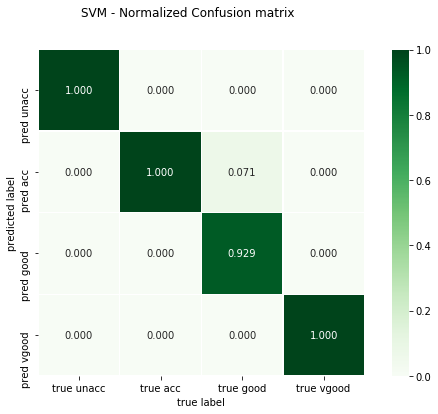

In [4]:
kernelList = ['rbf','linear','poly'] # rbf usa params C e gamma, linear apenas C, poly C,degree e coef0
kernel = 'rbf'
c = 7 # mais custoso e maior precisão, como o dataset tem apenas 1700 instancias não afeta tanto
gamma = 0.4 # aumentamos o raio de influencia de cada instancia

# chamda da função do svm
svc,s_pred, accuracy, errosSum = trainSVM(X_Train,X_Test,Y_Train,Y_Test,kernel,  c, gamma)
printResults(errosSum,accuracy)

confm = metrics.confusion_matrix(Y_Test, s_pred)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for _,val in outcome_labels.items()]
dfConfusionMatrix.index   = ['pred ' + str(val) for _,val in outcome_labels.items()]
sumPerActualQuality = dfConfusionMatrix.apply(sum, axis=0)
normalizerCM = dfConfusionMatrix.apply((lambda x: x/sumPerActualQuality), axis=1)

# heat map confusion não normalizada
fig = plt.figure(figsize=(10,6))
fig.suptitle('SVM - Confusion matrix')
fig.add_subplot(111)
sns.heatmap(dfConfusionMatrix, annot=True, square=True, cbar=True, fmt="d", linewidths=0.5, cmap='Greens')
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

# heat map confusion normalizada
fig = plt.figure(figsize=(10,6))
fig.suptitle('SVM - Normalized Confusion matrix')
fig.add_subplot(111)
sns.heatmap(normalizerCM, annot=True, square=True, cbar=True, fmt=".3f", linewidths=0.5, cmap='Greens')
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

### O resultado ficou muito bom, errando apenas uma classificação trocando uma instância "Boa" por "Aceitável"
### Refizemos o treino com 30% dos dados para teste e o SVM errou 11 classificações

# KNN
### Fizemos o knn variando o numero de vizinhos impares entre 3 e 13 e pegamos o melhor deles.
### No nosso caso o melhor numero de vizinhos foi 7, errando apenas 16 classificações  (~ 0.95 acc )

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def trainKnn(X_Train,Y_Train,X_Test,Y_Test):
    # Criando a Knn, testando o melhor numero de vizinhos para testar
    bestK = 1
    bestAccuracy = 0
    menorErro = 3000 # maior que o numero de amostras
    bestPredict = 0
    for i in range(3,13,2): #variando o K
        start = time.time()
        #criando o knn
        knn = KNeighborsClassifier(n_neighbors=i)
        # passando os dados de treino para o knn
        knn.fit(X_Train, Y_Train)
        print('Tempo de treino para k = {}: {} s'.format(i,time.time()-start))
        # Realizando a classificação com dados não usados no treino (dados de teste)
        predictions = knn.predict(X_Test)
        start = time.time()
        #comparando os resultados entre a classificação 'real' e o que a knn classificou para os casos de teste
        score = accuracy_score(Y_Test, predictions)
        print('Tempo de classificaçao dos testes para k = {}: {} s'.format(i,time.time()-start))
        if score > bestAccuracy:
            bestAccuracy = score
            bestK = i
            menorErro = (Y_Test!=predictions).sum()
            bestPredict = predictions
    
    return bestAccuracy,bestK, menorErro, bestPredict

def printResultsKnn(accuracy,k,erro):
    print('melhor resultado para a Knn: Score: {}, Numero de vizinhos: {}, numero de classificações errad: {}'.format(accuracy,k,erro))




Tempo de treino para k = 3: 0.002001523971557617 s
Tempo de classificaçao dos testes para k = 3: 0.0010004043579101562 s
Tempo de treino para k = 5: 0.001001119613647461 s
Tempo de classificaçao dos testes para k = 5: 0.0 s
Tempo de treino para k = 7: 0.0010020732879638672 s
Tempo de classificaçao dos testes para k = 7: 0.0 s
Tempo de treino para k = 9: 0.0010008811950683594 s
Tempo de classificaçao dos testes para k = 9: 0.0 s
Tempo de treino para k = 11: 0.0010008811950683594 s
Tempo de classificaçao dos testes para k = 11: 0.001001119613647461 s
melhor resultado para a Knn: Score: 0.953757225433526, Numero de vizinhos: 7, numero de classificações errad: 16


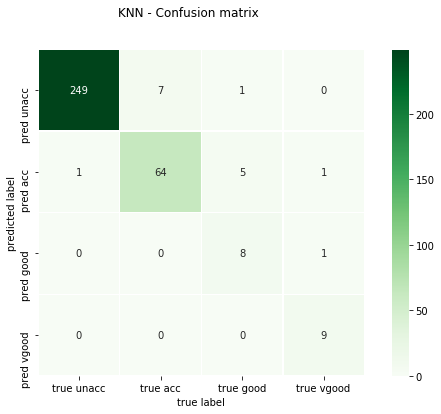

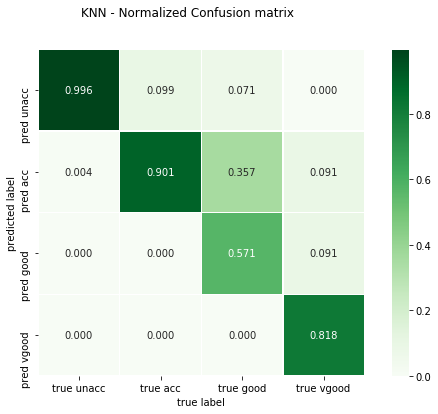

In [6]:
# Knn faz um for variando o numero de vizinhos
acc,k,erro,predictions = trainKnn(X_Train,Y_Train,X_Test,Y_Test)

printResultsKnn(acc,k,erro)

# criando a conf matrix
confm = metrics.confusion_matrix(Y_Test, predictions)
confmT = confm.T
dfConfusionMatrix = pd.DataFrame(confmT)
dfConfusionMatrix.columns = ['true ' + str(val) for _,val in outcome_labels.items()]
dfConfusionMatrix.index   = ['pred ' + str(val) for _,val in outcome_labels.items()]
sumPerActualQuality = dfConfusionMatrix.apply(sum, axis=0)
normalizerCM = dfConfusionMatrix.apply((lambda x: x/sumPerActualQuality), axis=1)

# heat map confusion não normalizada
fig = plt.figure(figsize=(10,6))
fig.suptitle('KNN - Confusion matrix')
fig.add_subplot(111)
sns.heatmap(dfConfusionMatrix, annot=True, square=True, cbar=True, fmt="d", linewidths=0.5, cmap='Greens')
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()

# heat map confusion normalizada
fig = plt.figure(figsize=(10,6))
fig.suptitle('KNN - Normalized Confusion matrix')
fig.add_subplot(111)
sns.heatmap(normalizerCM, annot=True, square=True, cbar=True, fmt=".3f", linewidths=0.5, cmap='Greens')
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.show()
    

## Por fim fizemos um comparativo com os algoritmos usados no dataset de wine fazendo varias repetições e plotando os resultados. 
## O SMV que fizemos o "fine tunnig" ficou com resultados muito bons, talvez indicando um overfit, no entanto, como mesmo variando entre 10% e 30% o percentual de amostras de teste não degrada demais os resultados. Acreditamos que ele é o melhor algoritmo para o dataset.

Text(0,0.5,'Accuracy')

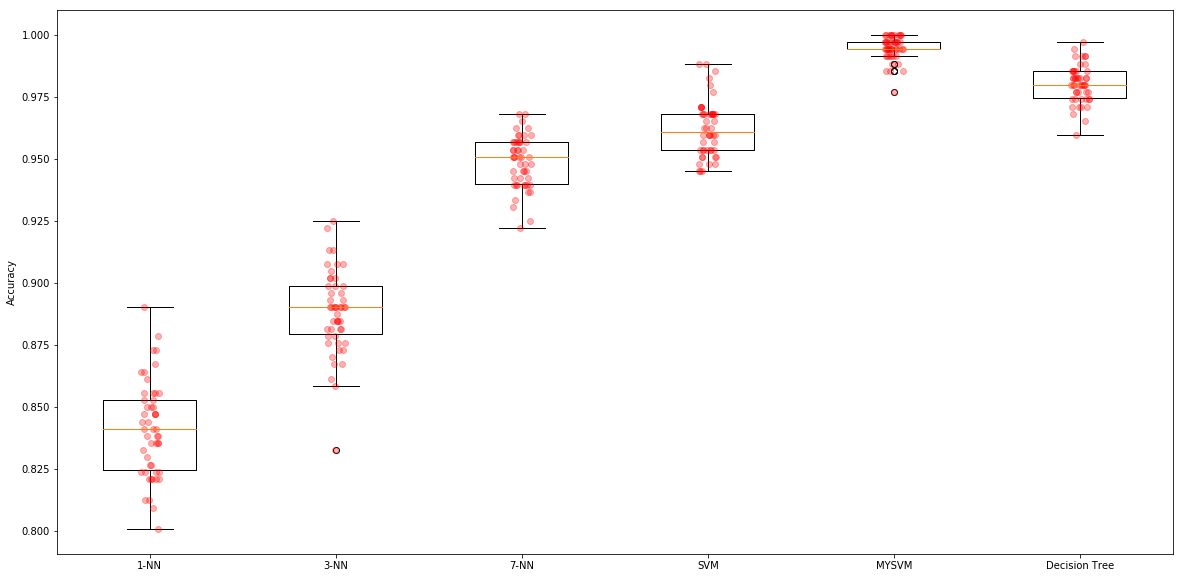

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import metrics

PRC = 0.2
# run 10 times, generating 4 models each time
acc_r=np.zeros((50,6))

# 10 iterations
for i in range(50):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=PRC)
    
    # configure 4 types of models
    nn1 = neighbors.KNeighborsClassifier(n_neighbors=1) # KNN com 1 vizinho
    nn3 = neighbors.KNeighborsClassifier(n_neighbors=3) # KNN com 3 vizinhos
    nn7 = neighbors.KNeighborsClassifier(n_neighbors=7) # KNN com 7 vizinhos Melhor resultado avaliado
    svc = svm.SVC(gamma='auto') # SVM
    mysvc= svm.SVC(kernel = 'rbf',C = 7,gamma=0.4) # SVM com fit (talvez overfit!?)
    dt = tree.DecisionTreeClassifier() # Decision Tree

    
    # train each model
    nn1.fit(X_train,Y_train)
    nn3.fit(X_train,Y_train)
    nn7.fit(X_train,Y_train)
    svc.fit(X_train,Y_train)
    mysvc.fit(X_train,Y_train)
    dt.fit(X_train,Y_train)
    
    # test each model
    Yhat_nn1=nn1.predict(X_test)
    Yhat_nn3=nn3.predict(X_test)
    Yhat_nn7=nn7.predict(X_test)
    Yhat_svc=svc.predict(X_test)
    Yhat_mysvc=mysvc.predict(X_test)
    Yhat_dt=dt.predict(X_test)
    
    # accuracy of each model at this iteration
    acc_r[i][0] = metrics.accuracy_score(Yhat_nn1, Y_test)
    acc_r[i][1] = metrics.accuracy_score(Yhat_nn3, Y_test)
    acc_r[i][2] = metrics.accuracy_score(Yhat_nn7, Y_test)
    acc_r[i][3] = metrics.accuracy_score(Yhat_svc, Y_test)
    acc_r[i][4] = metrics.accuracy_score(Yhat_mysvc, Y_test)
    acc_r[i][5] = metrics.accuracy_score(Yhat_dt, Y_test)

plt.figure(figsize=(20,10))
plt.boxplot(acc_r)
for i in range(6):
    xderiv = (i+1) * np.ones(acc_r[:,i].shape) + (np.random.rand(50,)-0.5) * 0.1
    plt.plot(xderiv, acc_r[:,i], 'ro', alpha=0.3)
    
ax = plt.gca()
ax.set_xticklabels(['1-NN', '3-NN','7-NN', 'SVM','MYSVM', 'Decision Tree'])
plt.ylabel('Accuracy')
#plt.savefig('figs/error_ms_1.png',dpi=300, bbox_inches='tight')